In [1]:
import sys
import os
import time

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from urllib.request import urlretrieve
from scipy.stats import pearsonr

from config.config import DATA_PATH
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_validate
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier

from sklearn.decomposition import PCA
from sklearn.svm import SVC


In [3]:
X_train = pd.read_csv(DATA_PATH + '/modeling/X_train.csv')
X_test = pd.read_csv(DATA_PATH + '/modeling/X_test.csv')
y_train = pd.read_csv(DATA_PATH + '/modeling/y_train.csv')
y_test = pd.read_csv(DATA_PATH + '/modeling/y_test.csv')

In [4]:
y_train = y_train['cancelled']
y_test = y_test['cancelled']

In [5]:
X_train.head()

,quarter,month,day_of_month,day_of_week,hour_of_day,scheduled_elapsed_time,distance,dep_delay_mean_10D,dep_delay_median_10D,dep_delay_max_10D,cancelled_sum_10D,div_airport_landings_sum_10D,n_flights_10D,dep_delay_mean_30D,dep_delay_median_30D,dep_delay_max_30D,cancelled_sum_30D,div_airport_landings_sum_30D,cancelled_sum_90D,div_airport_landings_sum_90D,temperature_2m_origin,precipitation_origin,snow_depth_origin,visibility_origin,wind_speed_10m_origin,wind_direction_10m_origin,wind_gusts_10m_origin,temperature_2m_dest,precipitation_dest,snow_depth_dest,visibility_dest,wind_speed_10m_dest,wind_direction_10m_dest,wind_gusts_10m_dest,origin_weather_impact_category,dest_weather_impact_category,origin_encoded,dest_encoded,airline_mkt_encoded,airline_ops_encoded,origin_division_encoded,dest_division_encoded,code_share_flight,is_holiday,dep_window_early afternoon,dep_window_early morning,dep_window_evening,dep_window_late night,dep_window_midday,dep_window_morning,dep_window_night,dep_window_overnight
0,-0.462372,-0.742801,1.627043,1.513039,-1.191404,0.962666,0.793271,-0.637097,-0.433316,-0.848334,-0.321698,-0.026067,-0.485351,-0.255407,-0.357089,1.020906,-0.455582,-0.044988,-0.613999,-0.075349,-0.378699,-0.059103,-0.09847,-0.803722,-1.054689,0.527084,0.099992,-0.765814,0.196989,-0.097696,-1.568529,2.247381,-1.538187,1.803467,-0.240644,4.093543,-0.392666,0.727335,0.790950,0.114362,-0.140199,1.415694,0,0,0,0,0,0,0,1,0,0
1,-1.361143,-1.035081,1.741076,0.513360,1.374386,0.864121,0.490951,0.410658,0.711883,-0.172918,-0.321698,-0.026067,-0.375945,-0.130465,0.046913,-0.854923,-0.455582,-0.044988,-0.613999,-0.075349,0.764768,-0.059103,-0.09847,-0.577887,0.383432,-0.133266,1.007014,-0.568275,-0.060985,-0.097696,-0.492279,-1.006400,-1.377210,-1.049016,-0.240644,-0.240942,-0.392666,2.555209,0.790950,0.114362,-0.140199,2.167403,0,0,0,0,0,0,0,0,1,0
2,-1.361143,-1.619639,1.627043,-1.485998,0.190175,2.879816,2.311011,-0.816002,-0.540678,-1.135745,-0.321698,-0.026067,-0.922973,-0.922882,-0.312199,-1.741141,-0.455582,-0.044988,-0.613999,-0.075349,-0.591698,-0.059103,-0.09847,1.214675,-0.078821,-1.023739,0.156681,-1.160893,-0.060985,-0.097696,-0.651376,-0.928929,0.725541,-0.441804,-0.240644,-0.240942,-0.503124,1.580374,-0.491204,-0.702297,-1.015747,2.167403,0,0,1,0,0,0,0,0,0,0
3,0.436398,0.426315,-0.197480,-1.485998,0.979649,0.210140,-0.346952,-0.292467,-0.075441,-0.560923,-0.321698,-0.026067,-0.485351,1.470541,0.226469,1.109528,1.075347,-0.044988,1.225667,-0.075349,2.266969,-0.059103,-0.09847,1.186446,-1.593984,-0.983718,-1.147163,1.102344,-0.060985,-0.097696,-0.698170,-0.903105,-0.260438,-0.921925,-0.240644,-0.240942,-0.392666,0.001885,0.790950,0.114362,-0.140199,-0.406655,0,0,0,0,1,0,0,0,0,0
4,1.335169,1.303153,1.627043,0.013520,-0.007193,-0.775311,-0.265617,-0.303767,-0.325953,-0.489070,-0.321698,-0.026067,-0.485351,-0.771946,-0.267310,-1.179869,-0.455582,-0.044988,-0.613999,-0.075349,-0.272200,-0.059103,-0.09847,1.054709,-0.258586,-0.133266,-0.353519,-1.262485,-0.060985,-0.097696,0.209624,0.465549,1.359384,-0.060532,-0.240644,-0.240942,-0.900817,-0.343188,-0.491204,-0.702297,-0.363483,-0.376839,0,0,1,0,0,0,0,0,0,0


## Model Selection, Evaluation and GridSearch Functions

In [6]:
cross_val_results = pd.DataFrame(columns=['model_name', 'model', 'mean_f1', 'mean_recall', 'mean_precision'])

In [9]:
def cross_validate_model(model_name, model, X_train, y_train):

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scoring = ['f1', 'recall', 'precision']

    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=kf, n_jobs=-1)

    mean_f1 = scores['test_f1'].mean()
    mean_recall = scores['test_recall'].mean()
    mean_precision = scores['test_precision'].mean()

    cross_val_results.loc[len(cross_val_results)] = [model_name, model, mean_f1, mean_recall, mean_precision]

    return cross_val_results


In [10]:
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, params=None):


    start_time = time.time()

    if params:
        model.set_params(**params)

    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    end_time = time.time()
    elapsed_time = end_time - start_time

    # calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    auprc = average_precision_score(y_test, y_pred_proba[:,1])

    model_params = model.get_params()

    
    metrics =  {
        'model_name': model_name,
        'model': model, 
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'auprc': auprc,
        'parameters': params if params else dict(model.get_params()),
        'training_testing_time_seconds': elapsed_time

    }

    print(f'Results for {model_name} model:')
    print('Classifcation report: \n', classification_report(y_test, y_pred))
    print()
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))

    return pd.DataFrame([metrics]), y_pred, y_pred_proba



In [11]:
def grid_search_model(model, params, X_train, y_train):

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    gs = GridSearchCV(model, param_grid=params, cv=kf, scoring='recall', n_jobs=-1)

    gs_fit = gs.fit(X_train, y_train)

    best_estimator, best_params = gs_fit.best_estimator_, gs_fit.best_params_

    return best_estimator, best_params

In [12]:
from sklearn.model_selection import RandomizedSearchCV

def random_grid_search_model(model, params, X_train, y_train):

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=40)

    rs  = RandomizedSearchCV(model, params, n_iter=50, n_jobs=-1, cv=kf)

    rs_fit = rs.fit(X_train, y_train)

    best_estimator, best_params = rs_fit.best_estimator_, rs_fit.best_params_

    return best_estimator, best_params

# Baseline Models & Performance

In [13]:
logreg_model = LogisticRegression()

log_reg_base_cv = cross_validate_model('LogReg_base_cv', logreg_model, X_train, y_train)

In [ ]:
model_dict = {
    'LogReg_base_cv': LogisticRegression(),
    'RF_base_cv': RandomForestClassifier(),
    'GB_base_cv': GradientBoostingClassifier(),
    'Balanced_RF_cv': BalancedRandomForestClassifier(),
    'Easy_Ensemble_cv': EasyEnsembleClassifier()
    
}

In [14]:
cross_val_results

,model_name,model,mean_f1,mean_recall,mean_precision
0,LogReg_base_cv,LogisticRegression(),0.075863,0.044381,0.261396


In [9]:
logreg_model = LogisticRegression()

log_reg_base_result, y_pred, y_pred_proba = evaluate_model('LogReg_base', logreg_model, X_train, y_train, X_test, y_test)

model_results = pd.DataFrame(log_reg_base_result)

Results for LogReg_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.25      0.04      0.08      6318

    accuracy                           0.98    448130
   macro avg       0.62      0.52      0.53    448130
weighted avg       0.98      0.98      0.98    448130


Confusion matrix: 
 [[440969    843]
 [  6035    283]]


In [10]:
rf_model = RandomForestClassifier(random_state=40)

rf_base_result, y_pred, y_pred_proba = evaluate_model('RF_base', rf_model, X_train, y_train, X_test, y_test)
model_results = pd.concat([model_results, rf_base_result], axis=0, ignore_index=True)

Results for RF_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.83      0.16      0.27      6318

    accuracy                           0.99    448130
   macro avg       0.91      0.58      0.63    448130
weighted avg       0.99      0.99      0.98    448130


Confusion matrix: 
 [[441603    209]
 [  5290   1028]]


In [11]:
svm_model = SVC(random_state=44)

svm_base_result, y_pred, y_pred_proba = evaluate_model('SVM_base', svm_model, X_train, y_train, X_test, y_test)
model_results = pd.concat([model_results, svm_base_result], axis=0, ignore_index=True)

AttributeError: This 'SVC' has no attribute 'predict_proba'

In [12]:
gb_model = GradientBoostingClassifier(random_state=44)

gb_base_result, y_pred, y_pred_proba = evaluate_model('GB_base', gb_model, X_train, y_train, X_test, y_test)
model_results = pd.concat([model_results, gb_base_result], axis=0, ignore_index=True)

Results for GB_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.73      0.09      0.17      6318

    accuracy                           0.99    448130
   macro avg       0.86      0.55      0.58    448130
weighted avg       0.98      0.99      0.98    448130


Confusion matrix: 
 [[441597    215]
 [  5724    594]]


In [13]:
knn_model = KNeighborsClassifier(n_neighbors=6)

knn_base_result, y_pred, y_pred_proba = evaluate_model('KNN_base', knn_model, X_train, y_train, X_test, y_test)
model_results = pd.concat([model_results, knn_base_result], axis=0, ignore_index=True)

Results for KNN_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.71      0.07      0.12      6318

    accuracy                           0.99    448130
   macro avg       0.85      0.53      0.56    448130
weighted avg       0.98      0.99      0.98    448130


Confusion matrix: 
 [[441637    175]
 [  5895    423]]


# Feature Selection

## PCA

In [14]:
cat_cols = ['code_share_flight', 'is_holiday', 'dep_window_early afternoon', 'dep_window_early morning', 'dep_window_evening', 'dep_window_late night', 'dep_window_midday', 'dep_window_morning',	'dep_window_night',	'dep_window_overnight']

In [15]:
X_train

,quarter,month,day_of_month,day_of_week,hour_of_day,scheduled_elapsed_time,distance,dep_delay_mean_10D,dep_delay_median_10D,dep_delay_max_10D,cancelled_sum_10D,div_airport_landings_sum_10D,n_flights_10D,dep_delay_mean_30D,dep_delay_median_30D,dep_delay_max_30D,cancelled_sum_30D,div_airport_landings_sum_30D,cancelled_sum_90D,div_airport_landings_sum_90D,temperature_2m_origin,precipitation_origin,snow_depth_origin,visibility_origin,wind_speed_10m_origin,wind_direction_10m_origin,wind_gusts_10m_origin,temperature_2m_dest,precipitation_dest,snow_depth_dest,visibility_dest,wind_speed_10m_dest,wind_direction_10m_dest,wind_gusts_10m_dest,origin_weather_impact_category,dest_weather_impact_category,origin_encoded,dest_encoded,airline_mkt_encoded,airline_ops_encoded,origin_division_encoded,dest_division_encoded,code_share_flight,is_holiday,dep_window_early afternoon,dep_window_early morning,dep_window_evening,dep_window_late night,dep_window_midday,dep_window_morning,dep_window_night,dep_window_overnight
0,0.436438,0.719041,0.486072,-0.485703,0.386492,-0.094424,-0.614352,0.065620,0.567564,-0.835053,-0.321680,-0.026341,-0.375666,0.193200,0.766390,-1.330031,-0.455562,-0.045265,-0.246778,-0.075259,0.942849,-0.059078,-0.098672,2.359261,0.279790,-0.594587,0.283613,1.072731,-0.061412,-0.098354,0.565356,0.076281,-0.502612,-0.443577,-0.240233,-0.240420,0.077159,-0.262727,-1.100361,-0.725061,-0.491078,-0.338423,0,0,0,0,0,0,0,0,0,0
1,0.436438,0.719041,-0.995811,0.014180,-0.995688,-0.963541,-1.313894,-0.303746,-0.505428,1.739221,-0.321680,-0.026341,2.366282,-0.188486,-0.493132,1.109301,-0.455562,-0.045265,4.164994,-0.075259,1.223239,-0.059078,-0.098672,0.122869,-1.569367,-0.534551,-1.657712,1.208130,-0.061412,-0.098354,-0.815260,0.024676,0.714815,-0.387134,-0.240233,4.104559,0.267293,-0.267591,0.822057,1.334963,-0.146414,-0.058323,1,0,0,0,0,0,0,1,0,0
2,-0.462880,-0.158230,1.284008,-0.985586,-0.995688,-0.685782,-1.149747,-0.474176,-0.362363,0.761284,-0.321680,-0.026341,1.708215,-0.403646,-0.538115,1.109301,-0.455562,-0.045265,1.223812,-0.075259,0.421324,-0.059078,-0.098672,-0.884685,-0.670471,-0.154329,-0.864177,0.886558,-0.061412,-0.098354,-0.038371,-0.929998,0.493464,-0.358913,-0.240233,-0.240420,0.352043,-0.948954,-0.641117,-0.590806,-0.374183,-0.388694,0,0,0,0,0,0,0,1,0,0
3,0.436438,0.134194,0.828044,1.513830,1.176308,-0.542422,0.850697,0.144458,0.352965,0.430512,-0.321680,-0.026341,0.611435,1.358170,1.351169,0.532732,2.597279,-0.045265,2.326755,-0.075259,1.363433,-0.059078,-0.098672,-0.126666,-0.028403,-0.144323,0.127740,-0.253051,-0.061412,-0.098354,-0.796540,-0.259146,1.026717,0.431286,-0.240233,-0.240420,-0.408900,-0.528773,0.822057,0.110743,-0.146414,-1.033289,0,0,0,0,0,0,0,0,1,0
4,1.335757,1.011465,1.739972,-0.985586,-0.008417,2.521886,1.645353,7.373149,13.085805,1.739221,-0.321680,-0.026341,-1.033733,6.804126,10.347757,1.109301,-0.455562,-0.045265,-0.614426,-0.075259,0.853124,-0.059078,-0.098672,2.693543,0.125693,-0.984815,-0.155665,-0.884913,-0.061412,-0.098354,-0.281734,-0.388156,-1.317583,-0.231917,-0.240233,-0.240420,-1.169456,1.484599,1.879437,1.538778,-0.491078,2.196495,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045629,0.436438,0.134194,-0.767829,1.513830,0.583946,-0.345303,-0.350490,0.209428,0.424498,-0.130364,-0.321680,-0.026341,-0.485344,1.164568,0.631442,0.577083,-0.455562,-0.045265,0.120869,-0.075259,1.441943,-0.059078,-0.098672,-0.187872,0.305473,-1.605179,-0.481581,1.134789,-0.061412,-0.098354,0.771279,1.908224,0.443158,1.475477,-0.240233,-0.240420,0.267293,-0.262727,-0.641117,-0.590806,-0.146414,-0.338423,0,0,0,0,0,0,0,0,0,0
1045630,-1.362199,-1.035500,0.828044,0.014180,-0.995688,-0.210904,-0.200150,0.286640,-0.433895,1.739221,-0.321680,-0.026341,1.708215,0.004267,-0.448149,1.109301,0.307648,-0.045265,-0.246778,-0.075259,-0.201141,-0.059

In [16]:
X_train_num = X_train.drop(columns=cat_cols)
X_test_num = X_test.drop(columns=cat_cols)

In [17]:
pca = PCA(n_components=0.95)
pca_fit = pca.fit(X_train_num)
X_train_num_pca = pca_fit.transform(X_train_num)
X_test_num_pca = pca_fit.transform(X_test_num)

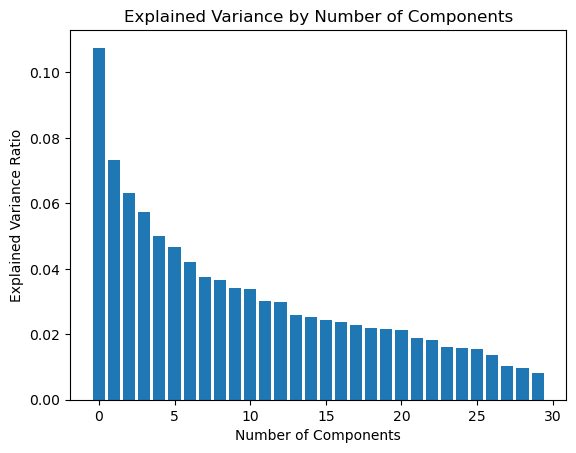

In [18]:
features = range(pca_fit.n_components_)
plt.bar(features, pca_fit.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Number of Components')
plt.show()

In [19]:
cols = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30']
loadings = pd.DataFrame(pca_fit.components_.T, columns=cols, index=X_train_num.columns)
loadings.sort_values('PC1', ascending=False)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
dep_delay_mean_30D,0.421936,-0.151993,-0.048952,0.001084,0.005465,-0.012350,0.023436,0.011846,0.050459,0.014202,0.024392,-0.007204,-0.035354,0.009093,-0.034683,0.000489,0.005041,-0.006933,0.007883,0.012018,0.014875,-0.015919,0.006071,0.011721,-0.028043,0.025000,0.086347,0.311728,0.049276,0.013592
dep_delay_mean_10D,0.416556,-0.145755,-0.047398,0.003752,0.025995,-0.037400,0.026906,0.055658,0.076252,0.010039,0.061215,-0.039804,-0.072209,0.025654,-0.024342,0.012172,0.005286,-0.023967,0.013088,0.018785,0.010054,0.040443,0.011511,-0.041391,0.062102,-0.020492,-0.198846,-0.311607,0.091412,-0.026627
dep_delay_median_10D,0.360182,-0.192358,-0.073250,-0.002463,0.002621,0.007883,0.061265,-0.043392,0.054995,0.123853,-0.023880,0.075848,-0.099108,0.077261,-0.115852,0.006692,0.004051,-0.097235,0.058045,0.164919,-0.028372,0.034757,0.252582,0.080338,-0.001941,-0.124030,-0.017988,-0.138813,-0.069870,0.012064
dep_delay_median_30D,0.355296,-0.200401,-0.074134,-0.004648,-0.003523,0.014659,0.059204,-0.062882,0.043354,0.120603,-0.041125,0.089395,-0.082280,0.070615,-0.118858,0.014168,0.010194,-0.096928,0.047954,0.152248,-0.023626,0.003794,0.250592,0.117097,-0.067719,-0.101346,0.173716,0.215943,-0.076274,0.026286
dep_delay_max_10D,0.302257,0.032990,0.059505,0.014265,0.089615,-0.140445,-0.039723,0.239760,0.106070,-0.172752,0.202425,-0.221715,-0.043325,-0.037921,0.099738,0.029867,0.000032,0.039683,-0.043820,-0.136664,0.035919,0.066016,-0.157193,-0.108403,0.084375,0.012793,-0.255900,-0.469581,0.112020,-0.039267
dep_delay_max_30D,0.264263,0.074986,0.101805,0.011224,0.074423,-0.130117,-0.067514,0.256435,0.084894,-0.213258,0.194686,-0.225346,0.005246,-0.073290,0.111238,-0.005318,-0.008612,0.081627,-0.052601,-0.167357,0.047021,0.000635,-0.198836,-0.065472,-0.004996,0.092772,0.069223,0.609077,0.047134,0.056043
cancelled_sum_30D,0.184470,0.286327,0.214652,0.047564,0.136442,-0.129983,-0.067369,-0.070352,-0.223157,0.140407,-0.245923,0.119091,-0.044431,0.052672,0.068299,-0.119564,-0.038860,-0.025978,-0.004715,-0.007925,-0.033716,0.079656,-0.031548,-0.012764,-0.022970,-0.009910,0.001017,0.043391,0.160968,-0.044836
hour_of_day,0.178051,-0.173795,-0.119883,-0.021029,-0.070373,0.141676,0.033378,-0.158610,-0.129142,0.136798,-0.152450,-0.078768,-0.076037,-0.174928,0.003932,-0.005769,0.026001,0.243690,-0.060938,-0.202779,-0.097602,0.139445,-0.478987,-0.117598,-0.183800,0.093038,0.404252,-0.195667,-0.340226,0.117117
cancelled_sum_10D,0.156190,0.230921,0.158592,0.039593,0.146305,-0.123296,-0.037013,-0.089333,-0.215113,0.166236,-0.263519,0.149083,-0.060268,0.098589,0.104799,-0.115266,-0.038457,-0.060535,-0.017195,-0.038336,0.001057,0.112720,-0.082798,-0.133687,0.194955,-0.026577,-0.417320,0.125019,-0.463927,0.055100
cancelled_sum_90D,0.154677,0.297826,0.279130,0.050148,0.059783,-0.076806,-0.068205,-0.028755,-0.163766,0.096783,-0.153221,0.038974,-0.039586,-0.014838,-0.003619,-0.053305,-0.019880,0.004453,-0.003838,-0.003844,-0.032575,0.017660,0.022856,0.095872,-0.195186,0.003446,0.373911,-0.160877,0.500089,-0.061283


In [20]:
X_train_final = np.concatenate([X_train_num_pca, X_train[cat_cols].values], axis=1)
X_test_final = np.concatenate([X_test_num_pca, X_test[cat_cols].values], axis=1)

In [21]:
log_reg_PCA = LogisticRegression()

log_reg_PCA_result, y_pred, y_pred_proba = evaluate_model('LogReg_pca_base', log_reg_PCA, X_train_final, y_train, X_test_final, y_test)
model_results = pd.concat([model_results, log_reg_PCA_result], axis=0, ignore_index=True)

Results for LogReg_pca_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.24      0.04      0.07      6318

    accuracy                           0.98    448130
   macro avg       0.61      0.52      0.53    448130
weighted avg       0.98      0.98      0.98    448130


Confusion matrix: 
 [[441000    812]
 [  6059    259]]


In [22]:
rf_model = RandomForestClassifier(random_state=44)

rf_PCA_result, y_pred, y_pred_proba = evaluate_model('RF_pca_base', rf_model, X_train_final, y_train, X_test_final, y_test)
model_results = pd.concat([model_results, rf_PCA_result], axis=0, ignore_index=True)


Results for RF_pca_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.75      0.04      0.07      6318

    accuracy                           0.99    448130
   macro avg       0.87      0.52      0.53    448130
weighted avg       0.98      0.99      0.98    448130


Confusion matrix: 
 [[441739     73]
 [  6096    222]]


## Feature Selection

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=20)
selector.fit(X_train, y_train)
X_train_reduced = selector.transform(X_train)

In [24]:
feature_scores = selector.scores_
feature_pvalues = selector.pvalues_
selected_features_mask = selector.get_support()
selected_features = X_train.columns[selected_features_mask]  # Assuming X_train is a DataFrame
# Combine feature names and their scores into a DataFrame
feature_scores_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': feature_scores,
    'P-Value': feature_pvalues
})

# Sort the features by score
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Display the top k features
top_k_features = feature_scores_df.head(30)
top_k_features

,Feature,Score,P-Value
10,cancelled_sum_10D,93808.190930,0.000000e+00
16,cancelled_sum_30D,38681.495846,0.000000e+00
18,cancelled_sum_90D,14367.995594,0.000000e+00
7,dep_delay_mean_10D,4722.131835,0.000000e+00
13,dep_delay_mean_30D,4562.920468,0.000000e+00
8,dep_delay_median_10D,3546.920016,0.000000e+00
14,dep_delay_median_30D,2676.864584,0.000000e+00
34,origin_weather_impact_category,1954.376436,0.000000e+00
39,airline_ops_encoded,1947.183833,0.000000e+00
30,visibility_dest,1622.786095,0.000000e+00


In [25]:
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

In [26]:
models = {
    'LinearRegression_red_features': {
        'model': LogisticRegression(random_state=44),
        'params': None},
    'RandomForest_red_features': {
        'model': RandomForestClassifier(random_state=44),
        'params': None},
    'GradientBoosting_red_features': {
        'model':GradientBoostingClassifier(random_state=44),
        'params':None}
}

In [27]:
for model_name, model_info in models.items():
    model = model_info['model']
    param_grid = model_info['params']
    
    # Evaluate the model
    if param_grid:
        metrics, y_pred, y_pred_proba = evaluate_model(model_name, model, X_train_reduced, y_train, X_test_reduced, y_test)
    else:
        metrics, y_pred, y_pred_proba = evaluate_model(model_name, model, X_train_reduced, y_train, X_test_reduced, y_test)
    
    # Append the results to the model_results DataFrame
    model_results = pd.concat([model_results, metrics], axis=0, ignore_index=True)

Results for LinearRegression_red_features model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.20      0.03      0.05      6318

    accuracy                           0.98    448130
   macro avg       0.59      0.51      0.52    448130
weighted avg       0.98      0.98      0.98    448130


Confusion matrix: 
 [[441007    805]
 [  6123    195]]
Results for RandomForest_red_features model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.61      0.08      0.14      6318

    accuracy                           0.99    448130
   macro avg       0.80      0.54      0.57    448130
weighted avg       0.98      0.99      0.98    448130


Confusion matrix: 
 [[441498    314]
 [  5824    494]]
Results for GradientBoosting_red_features model:
Classifcation report: 
               preci

### VIF

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]


In [29]:
vif_data.sort_values('VIF', ascending=False)
features_reduced = vif_data[vif_data['VIF'] < 5]
low_vif_features = features_reduced['Feature'].to_list()
low_vif_features

['day_of_month',
 'day_of_week',
 'scheduled_elapsed_time',
 'distance',
 'cancelled_sum_10D',
 'div_airport_landings_sum_10D',
 'n_flights_10D',
 'dep_delay_max_30D',
 'cancelled_sum_30D',
 'div_airport_landings_sum_30D',
 'cancelled_sum_90D',
 'div_airport_landings_sum_90D',
 'temperature_2m_origin',
 'precipitation_origin',
 'snow_depth_origin',
 'visibility_origin',
 'wind_speed_10m_origin',
 'wind_direction_10m_origin',
 'wind_gusts_10m_origin',
 'temperature_2m_dest',
 'precipitation_dest',
 'snow_depth_dest',
 'visibility_dest',
 'wind_speed_10m_dest',
 'wind_direction_10m_dest',
 'wind_gusts_10m_dest',
 'origin_weather_impact_category',
 'dest_weather_impact_category',
 'airline_mkt_encoded',
 'airline_ops_encoded',
 'code_share_flight',
 'is_holiday',
 'dep_window_early afternoon',
 'dep_window_early morning',
 'dep_window_evening',
 'dep_window_late night',
 'dep_window_midday',
 'dep_window_overnight']

In [ ]:
X_train_vif_reduced = X_train[low_vif_features]
X_test_vif_reduced = X_test[low_vif_features]

In [32]:


models = {
    'LogisticRegression_vif_features': {
        'model': LogisticRegression(random_state=44),
        'params': None},
    'RandomForest_vif_features': {
        'model': RandomForestClassifier(random_state=44),
        'params': None},
    'GradientBoosting_vif_features': {
        'model':GradientBoostingClassifier(random_state=44),
        'params':None}
}

In [33]:
for model_name, model_info in models.items():
    model = model_info['model']
    param_grid = model_info['params']
    
    # Evaluate the model
    if param_grid:
        metrics, y_pred, y_pred_proba = evaluate_model(model_name, model, X_train_vif_reduced, y_train, X_test_vif_reduced, y_test)
    else:
        metrics, y_pred, y_pred_proba = evaluate_model(model_name, model, X_train_vif_reduced, y_train, X_test_vif_reduced, y_test)
    
    # Append the results to the model_results DataFrame
    model_results = pd.concat([model_results, metrics], axis=0, ignore_index=True)

Results for LogisticRegression_vif_features model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.24      0.04      0.07      6318

    accuracy                           0.98    448130
   macro avg       0.61      0.52      0.53    448130
weighted avg       0.98      0.98      0.98    448130


Confusion matrix: 
 [[440962    850]
 [  6049    269]]
Results for RandomForest_vif_features model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.81      0.16      0.27      6318

    accuracy                           0.99    448130
   macro avg       0.90      0.58      0.63    448130
weighted avg       0.99      0.99      0.98    448130


Confusion matrix: 
 [[441572    240]
 [  5292   1026]]
Results for GradientBoosting_vif_features model:
Classifcation report: 
               pre

In [36]:
rf_bal_metrics, y_pred, y_pred_proba = evaluate_model('RF_balanced', RandomForestClassifier(class_weight='balanced'), 
                                               X_train_vif_reduced, y_train, X_test_vif_reduced, y_test)
model_results = pd.concat([model_results, rf_bal_metrics], axis=0, ignore_index=True)

Results for RF_balanced model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.82      0.11      0.20      6318

    accuracy                           0.99    448130
   macro avg       0.91      0.56      0.60    448130
weighted avg       0.99      0.99      0.98    448130


Confusion matrix: 
 [[441661    151]
 [  5608    710]]


In [39]:
rf_bal_sub_metrics, y_pred, y_pred_proba = evaluate_model('RF_balanced_sub', RandomForestClassifier(class_weight='balanced_subsample'), 
                                               X_train_vif_reduced, y_train, X_test_vif_reduced, y_test)
model_results = pd.concat([model_results, rf_bal_sub_metrics], axis=0, ignore_index=True)

Results for RF_balanced_sub model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.83      0.11      0.20      6318

    accuracy                           0.99    448130
   macro avg       0.91      0.56      0.59    448130
weighted avg       0.99      0.99      0.98    448130


Confusion matrix: 
 [[441670    142]
 [  5620    698]]


In [40]:

balanced_RF = BalancedRandomForestClassifier()

balanced_rf_metrics, y_pred, y_pred_proba = evaluate_model('Balanced_RF', balanced_RF, 
                                               X_train_vif_reduced, y_train, X_test_vif_reduced, y_test)
model_results = pd.concat([model_results, balanced_rf_metrics], axis=0, ignore_index=True)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementat

Results for Balanced_RF model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93    441812
           1       0.10      1.00      0.19      6318

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.56    448130
weighted avg       0.99      0.88      0.92    448130


Confusion matrix: 
 [[386891  54921]
 [     6   6312]]


In [43]:

easy_ensemble = EasyEnsembleClassifier()

easy_ensemble_metrics, y_pred, y_pred_proba = evaluate_model('Easy_Ensemble', easy_ensemble, 
                                               X_train_vif_reduced, y_train, X_test_vif_reduced, y_test)
model_results = pd.concat([model_results, easy_ensemble_metrics], axis=0, ignore_index=True)

Results for Easy_Ensemble model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    441812
           1       0.10      1.00      0.18      6318

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.56    448130
weighted avg       0.99      0.88      0.92    448130


Confusion matrix: 
 [[386109  55703]
 [     0   6318]]


In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

easy_ensemble = EasyEnsembleClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(model, X_train_vif_reduced, y_train, scoring='recall', cv=cv, n_jobs=-1)
scores.mean()

KeyboardInterrupt: 

In [50]:
model_results.to_csv('./model_results/model_results.10.25_v1.csv', index=False)

In [44]:
model_results.sort_values('recall', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters,training_testing_time_seconds
13,Easy_Ensemble,"((RandomUnderSampler(random_state=1839144522),...",0.875699,0.101869,1.000000,0.184902,0.963964,0.250732,"{'estimator': None, 'n_estimators': 10, 'n_job...",25.250789
12,Balanced_RF,"(DecisionTreeClassifier(max_features='sqrt', r...",0.877431,0.103082,0.999050,0.186881,0.970026,0.312254,"{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class...",13.858661
1,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987729,0.831043,0.162710,0.272138,0.973997,0.469510,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",73.010128
10,RF_balanced,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987149,0.824623,0.112377,0.197799,0.970189,0.429369,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",59.886441
11,RF_balanced_sub,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987142,0.830952,0.110478,0.195027,0.970756,0.428888,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",66.992011
2,GB_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.986747,0.734240,0.094017,0.166690,0.970053,0.360844,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",268.339116
9,GradientBoosting_vif_features,([DecisionTreeRegressor(criterion='friedman_ms...,0.986723,0.727723,0.093067,0.165029,0.969271,0.353383,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",187.907525
7,RandomForest_red_features,"(DecisionTreeClassifier(max_features='sqrt', r...",0.986303,0.611386,0.078189,0.138647,0.963682,0.295461,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",44.700374
3,KNN_base,KNeighborsClassifier(n_neighbors=6),0.986455,0.707358,0.066952,0.122325,0.751843,0.186499,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",404.518375
0,LogReg_base,LogisticRegression(),0.984652,0.251332,0.044793,0.076034,0.905328,0.164090,"{'C': 1.0, 'class_weight': None, 'dual': False...",1.937835


In [41]:
model_results = model_results.drop([9,10])

# Hyper Parameter Tuning

In [24]:
rf_param_grid = {
    'n_estimators':[350, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth':[3, 5, None],
    'max_features':['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'n_jobs': [-1], 
    'random_state':[40]}

best_model, best_params = grid_search_model(RandomForestClassifier(), params=rf_param_grid, X_train=X_train_reduced, y_train=y_train)

KeyboardInterrupt: 

In [150]:
rf_metrics, y_pred, y_pred_proba = evaluate_model(model_name='RF_reduced_grid_search', 
                                                  model=best_model, 
                                                  X_train=X_train_reduced, 
                                                  y_train=y_train, 
                                                  X_test=X_test_reduced, 
                                                  y_test=y_test, 
                                                  params=best_params)
    
model_results = pd.concat([model_results, rf_metrics], axis=0, ignore_index=True)

Results for RF_reduced_grid_search model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.68      0.06      0.10      6318

    accuracy                           0.99    448130
   macro avg       0.83      0.53      0.55    448130
weighted avg       0.98      0.99      0.98    448130


Confusion matrix: 
 [[441650    162]
 [  5970    348]]


In [151]:
model_results

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters
0,LogReg_base,LogisticRegression(),0.984652,0.251332,0.044793,0.076034,0.905328,0.164090,"{'C': 1.0, 'class_weight': None, 'dual': False..."
1,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987780,0.840065,0.164609,0.275278,0.973177,0.469523,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
2,GB_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.986747,0.734240,0.094017,0.166690,0.970053,0.360844,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
3,LogReg_pca_base,LogisticRegression(),0.984667,0.241830,0.040994,0.070104,0.899958,0.158830,"{'C': 1.0, 'class_weight': None, 'dual': False..."
4,RF_pca_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.986234,0.752542,0.035138,0.067140,0.940529,0.276127,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
5,GB_pca_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.985770,0.447415,0.039728,0.072976,0.942209,0.197646,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
6,LinearRegression,LogisticRegression(random_state=44),0.984540,0.195000,0.030864,0.053293,0.916535,0.139606,"{'C': 1.0, 'class_weight': None, 'dual': False..."
7,RandomForest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.986303,0.611386,0.078189,0.138647,0.963682,0.295461,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
8,GradientBoosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.986107,0.664286,0.029440,0.056381,0.963288,0.263669,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
9,RF_reduced_grid_search,"(DecisionTreeClassifier(criterion='entropy', m...",0.986316,0.682353,0.055081,0.101933,0.968305,0.319051,"{'n_estimators': 200, 'max_features': 'sqrt', ..."


In [25]:
rf_param_grid = {
    'n_estimators':[350, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth':[3, 5, None],
    'max_features':['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'n_jobs': [-1], 
    'random_state':[40]}

best_model_r, best_params_r = random_grid_search_model(RandomForestClassifier(), params=rf_param_grid, X_train=X_train, y_train=y_train)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [26]:
rf_metrics, y_pred, y_pred_proba = evaluate_model(model_name='RF_grid_search', 
                                                  model=best_model, 
                                                  X_train=X_train, 
                                                  y_train=y_train, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=best_params)
    
model_results = pd.concat([model_results, rf_metrics], axis=0, ignore_index=True)

Results for RF_grid_search model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.78      0.23      0.36      6318

    accuracy                           0.99    448130
   macro avg       0.88      0.62      0.68    448130
weighted avg       0.99      0.99      0.99    448130


Confusion matrix: 
 [[441385    427]
 [  4835   1483]]


In [27]:
model_results.sort_values('recall', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters
7,RF_grid_search,"(DecisionTreeClassifier(criterion='entropy', r...",0.988258,0.776440,0.234726,0.360476,0.977791,0.506163,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
1,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987729,0.831043,0.162710,0.272138,0.973997,0.469510,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
2,GB_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.986747,0.734240,0.094017,0.166690,0.970053,0.360844,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
5,RandomForest_red_features,"(DecisionTreeClassifier(max_features='sqrt', r...",0.986303,0.611386,0.078189,0.138647,0.963682,0.295461,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,KNN_base,KNeighborsClassifier(n_neighbors=6),0.986455,0.707358,0.066952,0.122325,0.751843,0.186499,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
0,LogReg_base,LogisticRegression(),0.984652,0.251332,0.044793,0.076034,0.905328,0.164090,"{'C': 1.0, 'class_weight': None, 'dual': False..."
4,LinearRegression_red_features,LogisticRegression(random_state=44),0.984540,0.195000,0.030864,0.053293,0.916535,0.139606,"{'C': 1.0, 'class_weight': None, 'dual': False..."
6,GradientBoosting_red_features,([DecisionTreeRegressor(criterion='friedman_ms...,0.986107,0.664286,0.029440,0.056381,0.963288,0.263669,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."


## Class Imbalance Techniques

In [49]:
undersampler = RandomUnderSampler(random_state=40)
X_train_rus, y_train_rus = undersampler.fit_resample(X_train, y_train)

rf_metrics, y_pred, y_pred_proba = evaluate_model(model_name='RF_random_undersample', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_rus, 
                                                  y_train=y_train_rus, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=best_params)
    
model_results = pd.concat([model_results, rf_metrics], axis=0, ignore_index=True)

Results for RF_under_sample model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    441812
           1       0.10      1.00      0.19      6318

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.56    448130
weighted avg       0.99      0.88      0.92    448130


Confusion matrix: 
 [[388040  53772]
 [    25   6293]]


In [14]:
undersampler_nm = NearMiss(version=1)

X_train_undersampled, y_train_undersampled = undersampler_nm.fit_resample(X_train, y_train)

In [42]:
rf_metrics, y_pred, y_pred_proba = evaluate_model(model_name='RF_undersample_nm_1', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_undersampled, 
                                                  y_train=y_train_undersampled, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=best_params)
    
model_results = pd.concat([model_results, rf_metrics], axis=0, ignore_index=True)

Results for RF_undersample_nm_bp model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96    441812
           1       0.13      0.82      0.22      6318

    accuracy                           0.92    448130
   macro avg       0.56      0.87      0.59    448130
weighted avg       0.98      0.92      0.95    448130


Confusion matrix: 
 [[406063  35749]
 [  1166   5152]]


In [ ]:
tomek = TomekLinks()

X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)

rf_metrics, y_pred, y_pred_proba = evaluate_model(model_name='RF_tomek', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_tomek, 
                                                  y_train=y_train_tomek, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=best_params)
    
model_results = pd.concat([model_results, rf_metrics], axis=0, ignore_index=True)

In [43]:
model_results.sort_values('recall', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters
8,RF_under_sample,"(DecisionTreeClassifier(criterion='entropy', r...",0.878881,0.104122,0.998259,0.188575,0.970602,0.348830,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
10,RF_undersample_nm_p3,"(DecisionTreeClassifier(criterion='entropy', r...",0.917745,0.126184,0.815923,0.218566,0.958633,0.213455,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
11,RF_undersample_nm_bp,"(DecisionTreeClassifier(criterion='entropy', r...",0.917624,0.125963,0.815448,0.218217,0.958597,0.213159,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
9,RF_undersample_nm_p2,"(DecisionTreeClassifier(criterion='entropy', r...",0.917589,0.125877,0.815131,0.218077,0.958621,0.213478,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
7,RF_grid_search,"(DecisionTreeClassifier(criterion='entropy', r...",0.988258,0.776440,0.234726,0.360476,0.977791,0.506163,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
1,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987729,0.831043,0.162710,0.272138,0.973997,0.469510,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
2,GB_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.986747,0.734240,0.094017,0.166690,0.970053,0.360844,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
5,RandomForest_red_features,"(DecisionTreeClassifier(max_features='sqrt', r...",0.986303,0.611386,0.078189,0.138647,0.963682,0.295461,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,KNN_base,KNeighborsClassifier(n_neighbors=6),0.986455,0.707358,0.066952,0.122325,0.751843,0.186499,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
0,LogReg_base,LogisticRegression(),0.984652,0.251332,0.044793,0.076034,0.905328,0.164090,"{'C': 1.0, 'class_weight': None, 'dual': False..."


In [44]:
model_results.to_csv('./model_results/model_results.10.25.csv', index=False)

In [38]:
params_2 = {'random_state': 40,
 'n_jobs': -1,
 'n_estimators': 600,
 'max_features': None,
 'max_depth': None,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

params_3 = {'random_state': 40,
 'n_jobs': -1,
 'n_estimators': 600,
 'max_features': None,
 'max_depth': None,
 'criterion': 'entropy',
 'class_weight': 'balanced_subsample'}

In [21]:
model_results = pd.read_csv('./model_results/model_results.10.25.csv')


In [23]:
undersampler_nm_3 = NearMiss(version=3, n_neighbors=10)

X_train_undersampled_3, y_train_undersampled_3 = undersampler_nm_3.fit_resample(X_train, y_train)

In [25]:
rf_metrics, y_pred, y_pred_proba = evaluate_model(model_name='RF_undersample_nm_3', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_undersampled_3, 
                                                  y_train=y_train_undersampled_3, 
                                                  X_test=X_test, 
                                                  y_test=y_test)
    
model_results = pd.concat([model_results, rf_metrics], axis=0, ignore_index=True)

Results for RF_undersample_nm_3 model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    441812
           1       0.12      0.89      0.21      6318

    accuracy                           0.90    448130
   macro avg       0.56      0.90      0.58    448130
weighted avg       0.99      0.90      0.94    448130


Confusion matrix: 
 [[399629  42183]
 [   712   5606]]


In [32]:
model_results.to_csv('./model_results/model_results.10.25.csv')

In [14]:
model_results.sort_values('recall', ascending=False)

,Unnamed: 0,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters
8,8.0,RF_under_sample,"RandomForestClassifier(criterion='entropy', ma...",0.878881,0.104122,0.998259,0.188575,0.970602,0.348830,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
12,NaN,RF_undersample_nm_3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.904280,0.117307,0.887306,0.207219,0.947417,0.123457,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
10,10.0,RF_undersample_nm_p3,RandomForestClassifier(class_weight='balanced_...,0.917745,0.126184,0.815923,0.218566,0.958633,0.213455,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
11,11.0,RF_undersample_nm_bp,"RandomForestClassifier(criterion='entropy', ma...",0.917624,0.125963,0.815448,0.218217,0.958597,0.213159,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
9,9.0,RF_undersample_nm_p2,RandomForestClassifier(class_weight='balanced'...,0.917589,0.125877,0.815131,0.218077,0.958621,0.213478,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
7,7.0,RF_grid_search,"RandomForestClassifier(criterion='entropy', ma...",0.988258,0.776440,0.234726,0.360476,0.977791,0.506163,"{'random_state': 40, 'n_jobs': -1, 'n_estimato..."
1,1.0,RF_base,RandomForestClassifier(random_state=40),0.987729,0.831043,0.162710,0.272138,0.973997,0.469510,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
2,2.0,GB_base,GradientBoostingClassifier(random_state=44),0.986747,0.734240,0.094017,0.166690,0.970053,0.360844,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
5,5.0,RandomForest_red_features,RandomForestClassifier(random_state=44),0.986303,0.611386,0.078189,0.138647,0.963682,0.295461,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,3.0,KNN_base,KNeighborsClassifier(n_neighbors=6),0.986455,0.707358,0.066952,0.122325,0.751843,0.186499,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."


In [141]:
gb_model = GradientBoostingClassifier(random_state=44)

gb_PCA_result, y_pred, y_pred_proba = evaluate_model('GB_pca_base', gb_model, X_train_final, y_train, X_test_final, y_test)
model_results = pd.concat([model_results, gb_PCA_result], axis=0, ignore_index=True)


Results for GB_pca_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441812
           1       0.45      0.04      0.07      6318

    accuracy                           0.99    448130
   macro avg       0.72      0.52      0.53    448130
weighted avg       0.98      0.99      0.98    448130


Confusion matrix: 
 [[441502    310]
 [  6067    251]]
